## Predicting Rent in Toronto

In this project I will look at rent in Toronto. The data was acquired from
https://www.kaggle.com/rajacsp/toronto-apartment-price.

Firstly, I will import the appropriate packages and data.

In [76]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score,mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import re
from xgboost import XGBRegressor
import seaborn as sns
from scipy import stats

Below I imported the data and removed the dollar signs from the prices.

In [77]:
all_data_df = pd.read_csv('Toronto_apartment_rentals_2018.csv')
all_data_df.head()
# Remove the dollar signs
all_data_df['Price'] = all_data_df['Price'].replace('[\$,]', '', regex=True).astype(float)
all_data_df.head()

,Bedroom,Bathroom,Den,Address,Lat,Long,Price
0,2,2.0,0,"3985 Grand Park Drive, 3985 Grand Park Dr, Mis...",43.581639,-79.648193,2450.0
1,1,1.0,1,"361 Front St W, Toronto, ON M5V 3R5, Canada",43.643051,-79.391643,2150.0
2,1,1.0,0,"89 McGill Street, Toronto, ON, M5B 0B1",43.660605,-79.378635,1950.0
3,2,2.0,0,"10 York Street, Toronto, ON, M5J 0E1",43.641087,-79.381405,2900.0
4,1,1.0,0,"80 St Patrick St, Toronto, ON M5T 2X6, Canada",43.652487,-79.389622,1800.0


Next I'll check for missing values. There are none.

In [78]:
all_data_df.isna().sum()

Bedroom     0
Bathroom    0
Den         0
Address     0
Lat         0
Long        0
Price       0
dtype: int64

For feature engineering, I will focus on the location. Instead of using
latitude and longitude, I will focus on the first three letters of the postal code as the first three letters can tell us
what neighbourhood the home is located in. The latitude and longitude are far too specific.



In [79]:
reg = re.compile('[LMlm]+\d+\D')
post_firstthree=[]
for add in all_data_df['Address']:
    ft_list = reg.findall(add)
    if ft_list == []:
        post_firstthree.append('NA')
    else:
        post_firstthree.append(ft_list[0])
all_data_df['postal'] = post_firstthree
all_data_df['postal'] = all_data_df['postal'].str.upper()
all_data_df = all_data_df.drop(['Address', 'Lat', 'Long'], axis=1)
all_data_df.head()
# city indicator- in our out of Toronto?



,Bedroom,Bathroom,Den,Price,postal
0,2,2.0,0,2450.0,L5B
1,1,1.0,1,2150.0,M5V
2,1,1.0,0,1950.0,M5B
3,2,2.0,0,2900.0,M5J
4,1,1.0,0,1800.0,M5T


Next I'll encode the postal codes as dummy variables.

In [80]:
all_data_df = pd.get_dummies(all_data_df)

Now I will do some data analysis. I will look for outliers and remove them from the data.

C:\Users\warre\anaconda3\envs\Toronto Rental Prices\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


,Bedroom,Bathroom,Den,Price,postal_L1A,postal_L1C,postal_L1G,postal_L1H,postal_L1J,postal_L1M,...,postal_M8V,postal_M8W,postal_M8X,postal_M8Y,postal_M9A,postal_M9B,postal_M9C,postal_M9N,postal_M9W,postal_NA
count,1124.000000,1124.000000,1124.000000,1124.000000,1124.000000,1124.000000,1124.000000,1124.000000,1124.000000,1124.000000,...,1124.000000,1124.000000,1124.000000,1124.000000,1124.000000,1124.000000,1124.000000,1124.000000,1124.000000,1124.000000
mean,1.370107,1.237544,0.153025,3627.912811,0.000890,0.000890,0.004448,0.008897,0.002669,0.000890,...,0.012456,0.000890,0.000890,0.004448,0.001779,0.003559,0.005338,0.009786,0.000890,0.019573
std,0.553493,0.431997,0.360172,27530.542058,0.029827,0.029827,0.066577,0.093944,0.051617,0.029827,...,0.110956,0.029827,0.029827,0.066577,0.042164,0.059575,0.072899,0.098485,0.029827,0.138589
min,1.000000,1.000000,0.000000,65.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,1759.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,2100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,1.000000,0.000000,2500.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.000000,3.000000,1.000000,535000.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


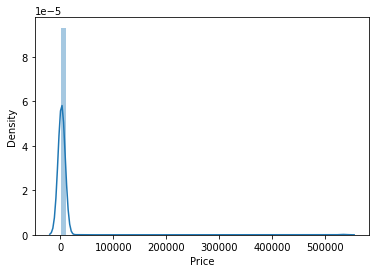

In [81]:
Y = all_data_df['Price']
sns.distplot(Y)
all_data_df.describe()

The rent prices are positively skewed, and so a transformation is needed.

C:\Users\warre\anaconda3\envs\Toronto Rental Prices\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count    1124.000000
mean        7.642809
std         0.480476
min         4.189655
25%         7.473211
50%         7.650169
75%         7.824446
max        13.190024
Name: Price, dtype: float64

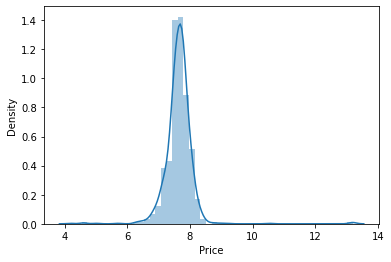

In [82]:
Y_transformed = np.log1p(Y)
sns.distplot(Y_transformed)
all_data_df['Price'] = Y_transformed
all_data_df['Price'].describe()

In [83]:
new_all_data = all_data_df[(np.abs(stats.zscore(all_data_df['Price'])) < 3)]
new_all_data.describe()

,Bedroom,Bathroom,Den,Price,postal_L1A,postal_L1C,postal_L1G,postal_L1H,postal_L1J,postal_L1M,...,postal_M8V,postal_M8W,postal_M8X,postal_M8Y,postal_M9A,postal_M9B,postal_M9C,postal_M9N,postal_M9W,postal_NA
count,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000,...,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000
mean,1.371634,1.236535,0.153501,7.636554,0.000898,0.000898,0.004488,0.008977,0.002693,0.000898,...,0.011670,0.000898,0.000898,0.004488,0.001795,0.003591,0.005386,0.009874,0.000898,0.018851
std,0.554443,0.430657,0.360632,0.321779,0.029961,0.029961,0.066875,0.094361,0.051847,0.029961,...,0.107442,0.029961,0.029961,0.066875,0.042352,0.059841,0.073224,0.098922,0.029961,0.136060
min,1.000000,1.000000,0.000000,6.311735,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,7.482119,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,7.650169,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,1.000000,0.000000,7.824446,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.000000,3.000000,1.000000,8.987322,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Now I'll split the data into a testing and training set.

In [84]:
trainX, testX, trainY, testY = train_test_split(new_all_data.drop(['Price'], axis=1), new_all_data['Price'])
trainX.shape
testX.shape


(279, 113)

## The model
Now it's time to create the model. I'll use the XGBRegressor.

In [85]:
model1 = XGBRegressor()
model1.fit(trainX, trainY)
predictions = np.exp(model1.predict(testX))

output= pd.DataFrame()
output['predictions'] = predictions
output.to_csv('predictions.csv', index=False)